__семантический сегментатор изображений__

Евгений Борисов borisov.e@solarl.ru

https://github.com/YunYang1994/TensorFlow2.0-Examples/tree/master/5-Image_Segmentation/FCN

https://arxiv.org/pdf/1411.4038.pdf

In [1]:
# from IPython.core.interactiveshell import InteractiveShell
# InteractiveShell.ast_node_interactivity = "all"

In [2]:
import gc
from os.path import join as pjoin
import numpy as np
import matplotlib.pyplot as plt
# from matplotlib import cm

In [3]:
import tensorflow as tf
tf.__version__

'2.3.1'

In [4]:
# default GPU device
if tf.test.is_built_with_cuda():
    print([ 
          d.physical_device_desc 
          for d in tf.python.client.device_lib.list_local_devices() 
          if d.device_type == 'GPU' and d.name==tf.test.gpu_device_name()
        ])

['device: 0, name: GeForce GTX 1060 6GB, pci bus id: 0000:01:00.0, compute capability: 6.1']


---

In [5]:
# !mkdir -p result/fcn

In [6]:
FOLDER_DATA = 'data/pascal_my'
FOLDER_RESULT = 'result/fcn'

In [7]:
# x_train = np.vstack([
#           np.load(pjoin(FOLDER_DATA,'x_train.npy')),
#           np.load(pjoin(FOLDER_DATA,'x_train_aug.npy'))
#         ])

x_train = np.load(pjoin(FOLDER_DATA,'x_train.npy'))
x_train.shape

(3335, 256, 256, 3)

In [8]:
y_train = np.load(pjoin(FOLDER_DATA,'y_train.npy'))
# y_train = np.vstack([y_train,y_train])
y_train.shape

(3335, 256, 256)

In [9]:
gc.collect()

119

---

In [12]:
# сводим задачу к бинарной классификации

# выбираем класс с максимальным количеством примеров
n,w,h = y_train.shape
n_samples_class = [ (y_train.reshape(n,w*h)==c+1).any(axis=-1).sum() for c in range(y_train.max()) ]
n_samples_class_max = np.argmax(n_samples_class)+1

# n_samples_class_max,n_samples_class[n_samples_class_max-1],n_samples_class

# выбираем примеры с найденным номером класса
y_train_mono = (y_train==n_samples_class_max)
y_train_mono_label = y_train_mono.any(axis=-1).any(axis=-1)


x_train_mono = x_train[y_train_mono_label,:]
y_train_mono = y_train_mono[y_train_mono_label,:].astype(np.uint8)

n_class=2

x_train_mono.shape, y_train_mono.shape

((1059, 256, 256, 3), (1059, 256, 256))

In [13]:
x_train_mono.min(),x_train_mono.max(),  y_train_mono.min(),y_train_mono.max()

(-2.117904, 2.64, 0, 1)

In [14]:
x_train,y_train = x_train_mono, y_train_mono

In [15]:
gc.collect()

45

---

In [16]:
class FCN8s(tf.keras.Model):
    def __init__(self, n_class=21):
        super(FCN8s, self).__init__()
        # conv1
        self.conv1_1 = tf.keras.layers.Conv2D(64, 3, activation='relu', padding='valid')
        self.conv1_2 = tf.keras.layers.Conv2D(64, 3, activation='relu', padding='same')
        self.pool1   = tf.keras.layers.MaxPooling2D(2, strides=2, padding='same') # 1/2

        # conv2
        self.conv2_1 = tf.keras.layers.Conv2D(128, 3, activation='relu', padding='same')
        self.conv2_2 = tf.keras.layers.Conv2D(128, 3, activation='relu', padding='same')
        self.pool2   = tf.keras.layers.MaxPooling2D(2, strides=2, padding='same') # 1/4

        # conv3
        self.conv3_1 = tf.keras.layers.Conv2D(256, 3, activation='relu', padding='same')
        self.conv3_2 = tf.keras.layers.Conv2D(256, 3, activation='relu', padding='same')
        self.conv3_3 = tf.keras.layers.Conv2D(256, 3, activation='relu', padding='same')
        self.pool3   = tf.keras.layers.MaxPooling2D(2, strides=2, padding='same') # 1/8

        # conv4
        self.conv4_1 = tf.keras.layers.Conv2D(512, 3, activation='relu', padding='same')
        self.conv4_2 = tf.keras.layers.Conv2D(512, 3, activation='relu', padding='same')
        self.conv4_3 = tf.keras.layers.Conv2D(512, 3, activation='relu', padding='same')
        self.pool4   = tf.keras.layers.MaxPooling2D(2, strides=2, padding='same') # 1/16

        # conv5
        self.conv5_1 = tf.keras.layers.Conv2D(512, 3, activation='relu', padding='same')
        self.conv5_2 = tf.keras.layers.Conv2D(512, 3, activation='relu', padding='same')
        self.conv5_3 = tf.keras.layers.Conv2D(512, 3, activation='relu', padding='same')
        self.pool5   = tf.keras.layers.MaxPooling2D(2, strides=2, padding='same') # 1/32

        # fc6
        self.fc6 = tf.keras.layers.Conv2D(4096, 7, activation='relu', padding='valid')
        self.drop6 = tf.keras.layers.Dropout(0.5)

        # fc7
        self.fc7 = tf.keras.layers.Conv2D(4096, 1, activation='relu', padding='valid')
        self.drop7 = tf.keras.layers.Dropout(0.5)

        self.socre_fr = tf.keras.layers.Conv2D(n_class, 1)
        self.score_pool3 = tf.keras.layers.Conv2D(n_class, 1)
        self.score_pool4 = tf.keras.layers.Conv2D(n_class, 1)

        self.upscore2 = tf.keras.layers.Conv2DTranspose(n_class,4,strides=2,padding='valid',use_bias=False)
        self.upscore8 = tf.keras.layers.Conv2DTranspose(n_class,16,strides=8,padding='valid',use_bias=False)
        self.upscore_pool4 = tf.keras.layers.Conv2DTranspose(n_class,4,strides=2,padding='valid',use_bias=False)

        # https://datascience.stackexchange.com/questions/6107/what-are-deconvolutional-layers
        # https://slideplayer.com/slide/15353689/92/images/5/Transposed+Convolution+%28Deconvolution%29.jpg
        
    def call(self, x, training=False):
        h = x
        h = self.conv1_1(tf.keras.layers.ZeroPadding2D(padding=(100,100))(h))
        h = self.conv1_2(h)
        h = self.pool1(h)

        h = self.conv2_1(h)
        h = self.conv2_2(h)
        h = self.pool2(h)

        h = self.conv3_1(h)
        h = self.conv3_2(h)
        h = self.conv3_3(h)
        h = self.pool3(h)
        pool3 = h # 1/8

        h = self.conv4_1(h)
        h = self.conv4_2(h)
        h = self.conv4_3(h)
        h = self.pool4(h)
        pool4 = h # 1/16

        h = self.conv5_1(h)
        h = self.conv5_2(h)
        h = self.conv5_3(h)
        h = self.pool5(h)

        h = self.fc6(h)
        h = self.drop6(h, training)

        h = self.fc7(h)
        h = self.drop7(h, training)

        h = self.socre_fr(h)
        h = self.upscore2(h)
        upscore2 = h # 1/16
        # print(upscore2.shape)

        h = self.score_pool4(pool4 * 0.01) # XXX: scaling to train at onece
        h = h[:, 5:5+upscore2.shape[1], 5:5+upscore2.shape[2], :] # channel last
        score_pool4c = h # 1/16

        h = upscore2 + score_pool4c # 1/16
        h = self.upscore_pool4(h)
        upscore_pool4 = h # 1/8

        h = self.score_pool3(pool3 * 0.0001) # XXX: scaling to train at onece
        h = h[:, 9:9+upscore_pool4.shape[1], 9:9+upscore_pool4.shape[2], :] # channel last
        score_pool3c = h # 1/8

        h = upscore_pool4 + score_pool3c # 1/8

        h = self.upscore8(h)
        h = h[:, 31:31+x.shape[1], 31:31+x.shape[2], :] # channel last

        return tf.nn.softmax(h, axis=-1)

In [17]:
BATCH_SIZE = 8
LEARNING_RATE = 1e-4

model = FCN8s(n_class=n_class)
optimizer=tf.keras.optimizers.Adam(lr=LEARNING_RATE)
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy',  metrics=['accuracy'])

CPU times: user 70.9 ms, sys: 53.9 ms, total: 125 ms
Wall time: 124 ms


In [18]:
# model.fit(x_train,y_train, batch_size=BATCH_SIZE, epochs=1)

In [19]:
%%time 

model.fit(x_train,y_train, batch_size=BATCH_SIZE, epochs=100)

Epoch 1/100
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
133/133 [==============================] - 153s 1s/step - loss: 0.6696 - accuracy: 0.5800
Epoch 2/100
133/133 [==============================] - 151s 1s/step - loss: 0.5236 - accuracy: 0.7751
Epoch 3/100
133/133 [==============================] - 151s 1s/step - loss: 0.4376 - accuracy: 0.8279
Epoch 4/100
133/133 [==============================] - 151s 1s/step - loss: 0.3906 - accuracy:

In [20]:
model.save_weights( pjoin(FOLDER_RESULT,'model_weight_100.h5') )

In [1]:
# %%time 

# n_train_samples = y_train.shape[0]
# ii = np.random.permutation(n_train_samples)
# x_train = x_train[ii,:]
# y_train = y_train[ii,:]

# tf.keras.backend.set_value(model.optimizer.learning_rate, 1e-5)

# model.fit(x_train,y_train, batch_size=BATCH_SIZE, epochs=20)

In [22]:
# model.save_weights( pjoin(FOLDER_RESULT,'model_weight_120.h5') )

In [2]:
# %%time 

# n_train_samples = y_train.shape[0]
# ii = np.random.permutation(n_train_samples)
# x_train = x_train[ii,:]
# y_train = y_train[ii,:]

# tf.keras.backend.set_value(model.optimizer.learning_rate, 1e-6)

# model.fit(x_train,y_train, batch_size=BATCH_SIZE, epochs=5)

In [3]:
# model.save_weights( pjoin(FOLDER_RESULT,'model_weight_125.h5') )

---

In [27]:
def data2img(x):
    img = (x-x.min())/(x.max()-x.min()) if x.max()>0 else x
    img = (img*255.).astype(np.uint8)
    return img.reshape(x.shape[1:])

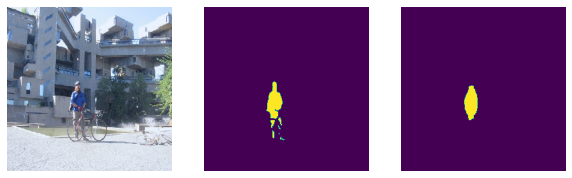

In [63]:
n_train_samples = x_train.shape[0]
i = np.random.randint(n_train_samples)

x = x_train[i-1:i,:]
y = y_train[i-1:i,:]

p = model.predict(x)
r = np.argmax(p,axis=-1) if (y_train.max()>1) else (p[:,:,:,1]>.5).astype(np.uint8)

fig,ax = plt.subplots(1,3,figsize=(10,5))

ax[0].axis(False)
ax[0].imshow(data2img(x))

ax[1].axis(False)
ax[1].imshow(data2img(y))

ax[2].axis(False)
ax[2].imshow(data2img(r))

In [59]:
# set(r.flatten())

---

In [70]:
x_test = np.load(pjoin(FOLDER_DATA,'x_test.npy'))
x_test.shape

y_test = np.load(pjoin(FOLDER_DATA,'y_test.npy'))
# y_train = np.vstack([y_train,y_train])
y_test.shape

# n_samples_class_max

# сводим задачу к бинарной классификации

# выбираем примеры с найденным номером класса
y_test_mono = (y_test==n_samples_class_max)
y_test_mono_label = y_test_mono.any(axis=-1).any(axis=-1)

x_test_mono = x_test[y_test_mono_label,:]
y_test_mono = y_test_mono[y_test_mono_label,:].astype(np.uint8)

# x_test_mono.shape, y_test_mono.shape

x_test,y_test = x_test_mono, y_test_mono

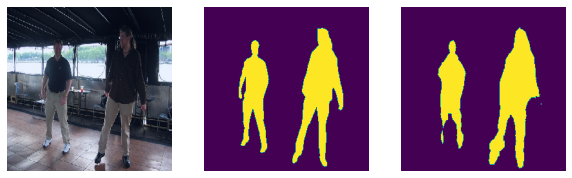

In [82]:
n_test_samples = x_test.shape[0]
i = np.random.randint(n_test_samples)

x = x_test[i-1:i,:]
y = y_test[i-1:i,:]

p = model.predict(x)
r = np.argmax(p,axis=-1) if (y_test.max()>1) else (p[:,:,:,1]>.5).astype(np.uint8)

fig,ax = plt.subplots(1,3,figsize=(10,5))

ax[0].axis(False)
ax[0].imshow(data2img(x))

ax[1].axis(False)
ax[1].imshow(data2img(y))

ax[2].axis(False)
ax[2].imshow(data2img(r))